In [108]:
import matplotlib.pylab as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns

from ocddetection.data import SENSORS

In [2]:
def read_meta(path):
    df = pd.read_csv(path, index_col=0)
    df.index = pd.TimedeltaIndex(df.index).rename('ms')
    
    return df

In [3]:
meta = [
    [
        read_meta(f'./data/S{subject}-ADL{run}-META.csv')
        for run in range(1, 6)
    ]
    for subject in range(1, 5)
]

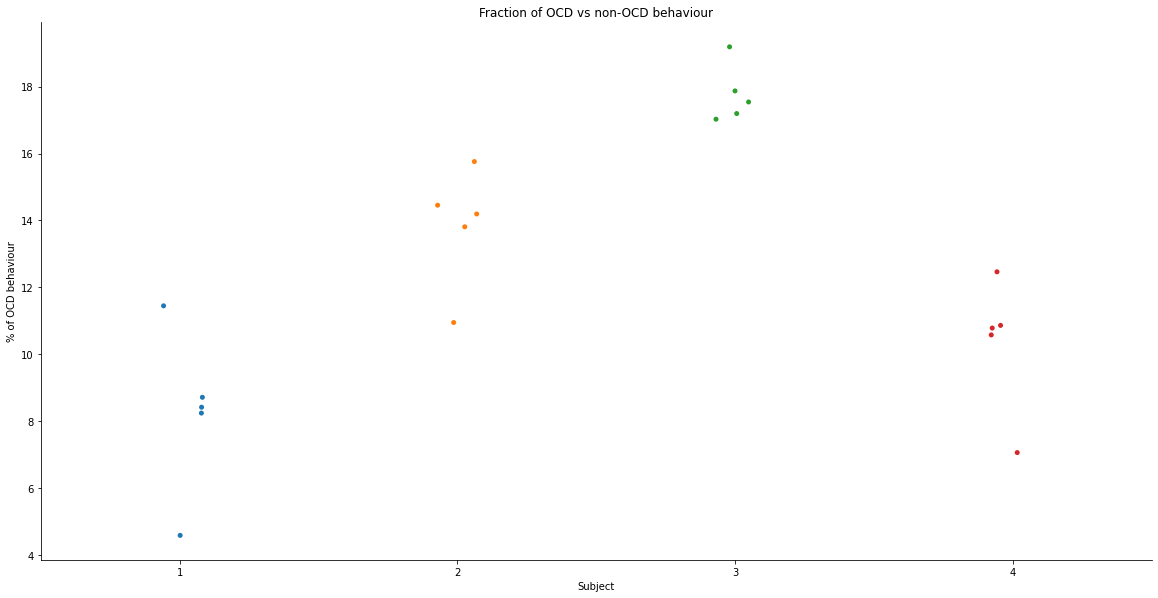

In [4]:
data = np.array([[run['ocd'].sum() / len(run) * 100 for run in adl] for adl in meta]).T
    
grid = sns.catplot(data=pd.DataFrame(data, columns=range(1, 5)), height=8, aspect=2)
grid.set(
    title='Fraction of OCD vs non-OCD behaviour',
    xlabel='Subject',
    ylabel='% of OCD behaviour'
)

plt.show()

In [5]:
def read_augmented(tup):
    return pd.read_csv(
        f'./data/S{tup[0] + 1}-ADL{tup[1] + 1}-AUGMENTED.csv',
        header=None
    )

In [6]:
highest = np.unravel_index(np.argmax(data.T, axis=None), data.T.shape)

In [7]:
df_highest = meta[highest[0]][highest[1]].reset_index().join(read_augmented(highest)).set_index('ms')

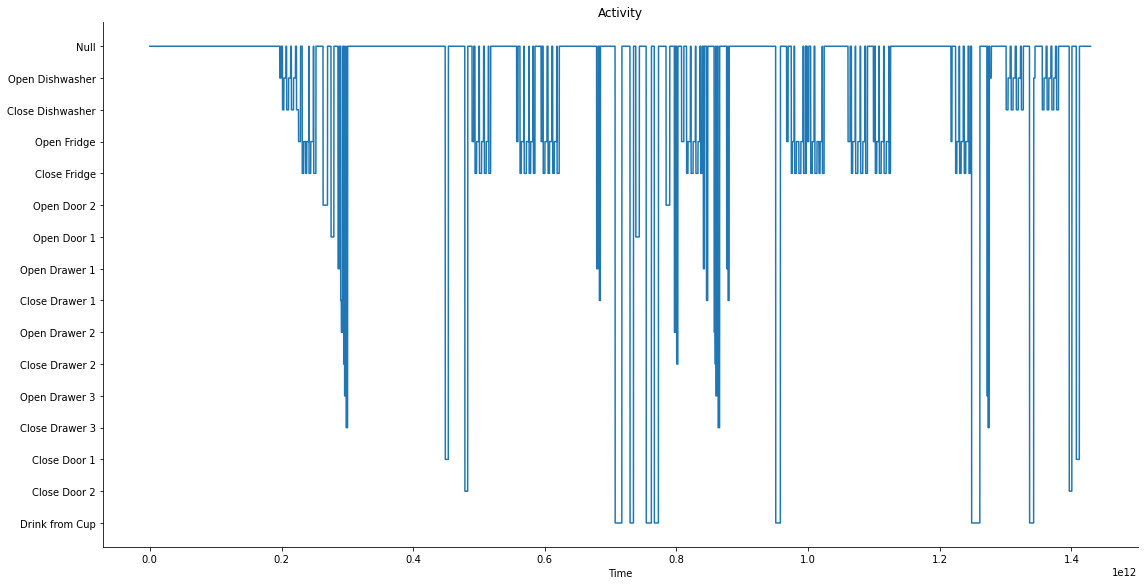

In [14]:
grid = sns.relplot(data=df_highest['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()

In [8]:
df_highest_fridge = df_highest.loc['3min 45s 795ms': '4min 12s 200ms']

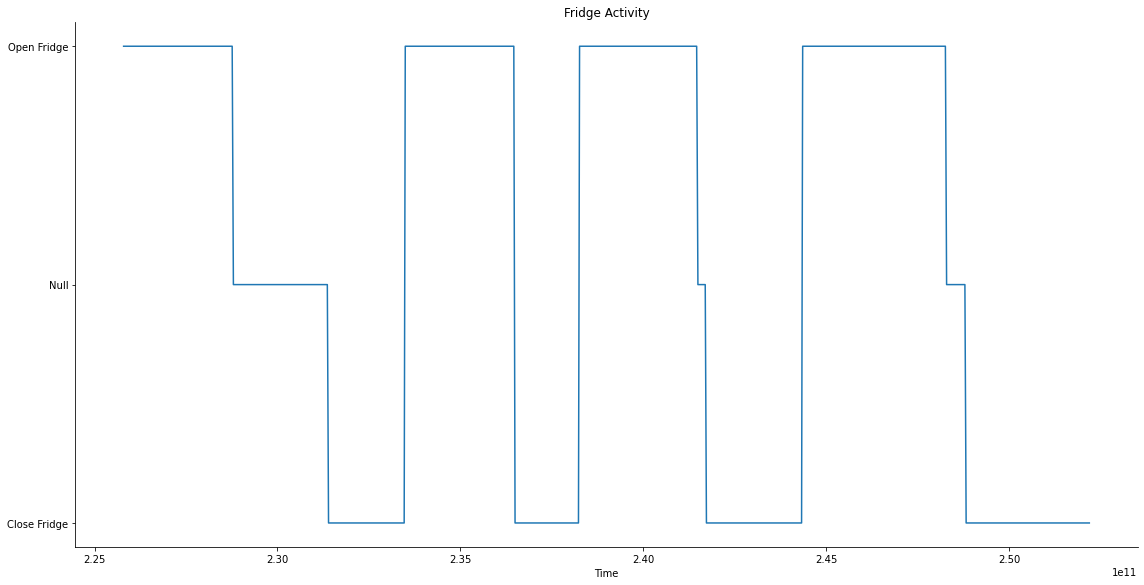

In [9]:
grid = sns.relplot(data=df_highest_fridge['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Fridge Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()

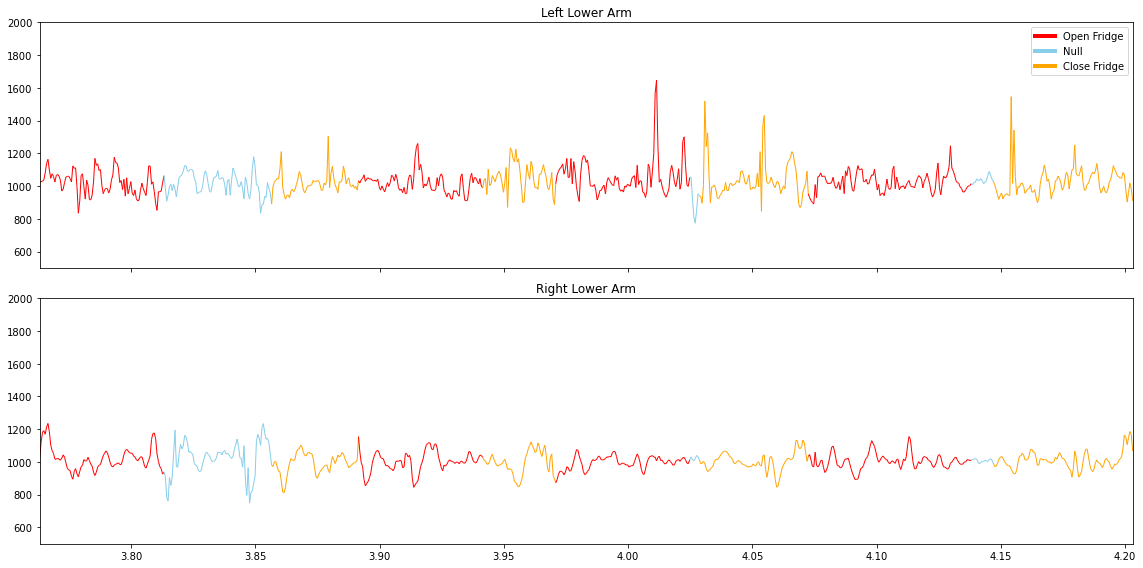

In [112]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

label_dict = {'Open Fridge': -1, 'Null': 0, 'Close Fridge': 1}
cmap = ListedColormap(['red', 'skyblue', 'orange'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

x = df_highest_fridge.index.values.astype(np.float32) / 60000000000
labels = df_highest_fridge['activity'].replace(label_dict)

# Left
y = np.sqrt(np.square(df_highest_fridge[36]) + np.square(df_highest_fridge[37]) + np.square(df_highest_fridge[38]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[0].add_collection(lc)

axs[0].set_title('Left Lower Arm')
axs[0].set_xlim(x[0], x[-1])
axs[0].set_ylim(500, 2000)

# Right
y = np.sqrt(np.square(df_highest_fridge[18]) + np.square(df_highest_fridge[19]) + np.square(df_highest_fridge[20]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[1].add_collection(lc)

axs[1].set_title('Right Lower Arm')
axs[1].set_xlim(x[0], x[-1])
axs[1].set_ylim(500, 2000)

axs[0].legend(
    [
        Line2D([0], [0], color='red', lw=4),
        Line2D([0], [0], color='skyblue', lw=4),
        Line2D([0], [0], color='orange', lw=4)
    ],
    label_dict.keys()
)

plt.tight_layout()
plt.show()

In [129]:
df_highest_dishwasher = df_highest.loc['3min 17s 795ms': '3min 45s 755ms']

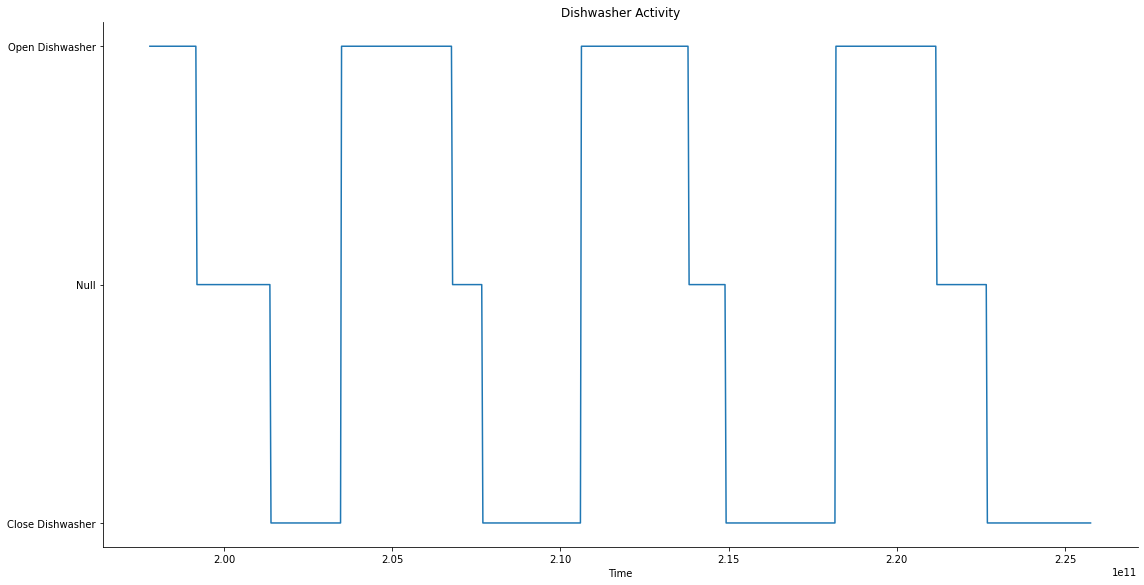

In [130]:
grid = sns.relplot(data=df_highest_dishwasher['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Dishwasher Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()

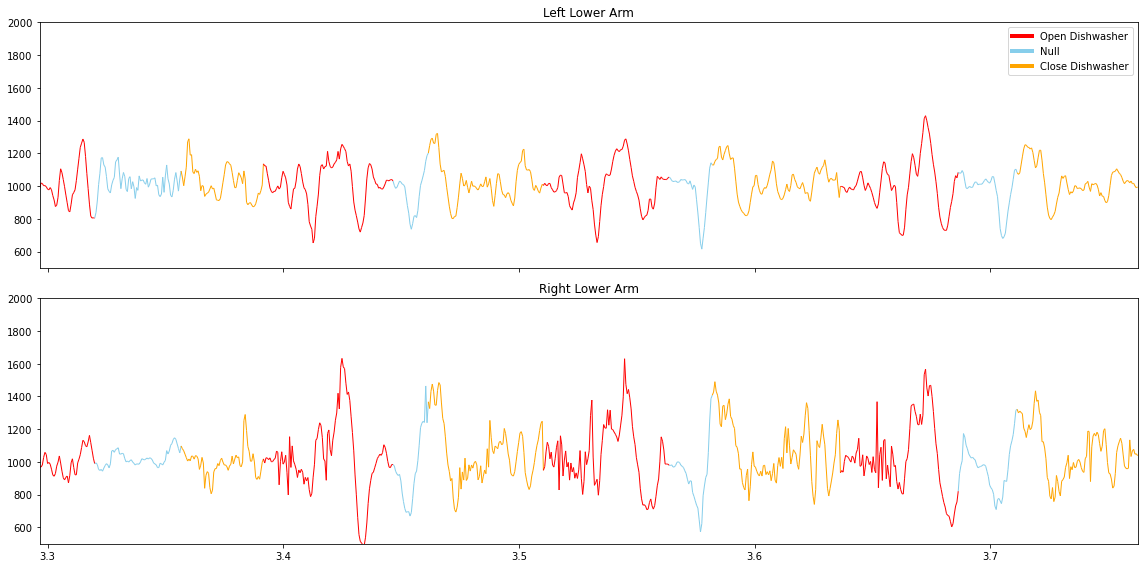

In [131]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

label_dict = {'Open Dishwasher': -1, 'Null': 0, 'Close Dishwasher': 1}
cmap = ListedColormap(['red', 'skyblue', 'orange'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

x = df_highest_dishwasher.index.values.astype(np.float32) / 60000000000
labels = df_highest_dishwasher['activity'].replace(label_dict)

# Left
y = np.sqrt(np.square(df_highest_dishwasher[36]) + np.square(df_highest_dishwasher[37]) + np.square(df_highest_dishwasher[38]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[0].add_collection(lc)

axs[0].set_title('Left Lower Arm')
axs[0].set_xlim(x[0], x[-1])
axs[0].set_ylim(500, 2000)

# Right
y = np.sqrt(np.square(df_highest_dishwasher[18]) + np.square(df_highest_dishwasher[19]) + np.square(df_highest_dishwasher[20]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[1].add_collection(lc)

axs[1].set_title('Right Lower Arm')
axs[1].set_xlim(x[0], x[-1])
axs[1].set_ylim(500, 2000)

axs[0].legend(
    [
        Line2D([0], [0], color='red', lw=4),
        Line2D([0], [0], color='skyblue', lw=4),
        Line2D([0], [0], color='orange', lw=4)
    ],
    label_dict.keys()
)

plt.tight_layout()
plt.show()

In [10]:
lowest = np.unravel_index(np.argmin(data.T, axis=None), data.T.shape)

In [11]:
df_lowest = meta[lowest[0]][lowest[1]].reset_index().join(read_augmented(lowest)).set_index('ms')

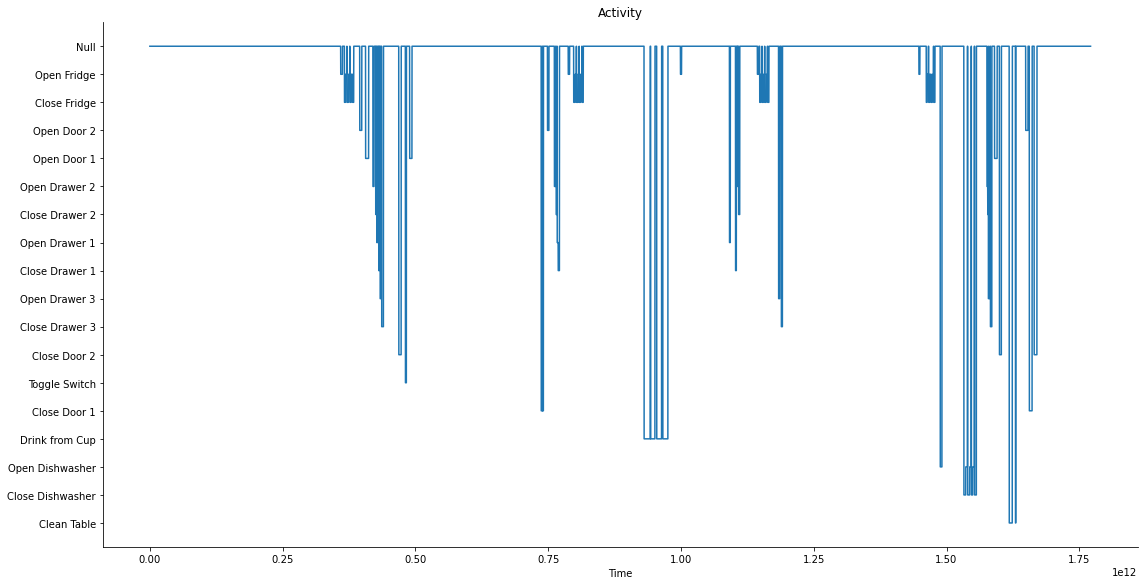

In [15]:
grid = sns.relplot(data=df_lowest['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()

In [12]:
df_lowest_fridge = df_lowest.loc['5min 59s 200ms': '6min 23s 750ms']

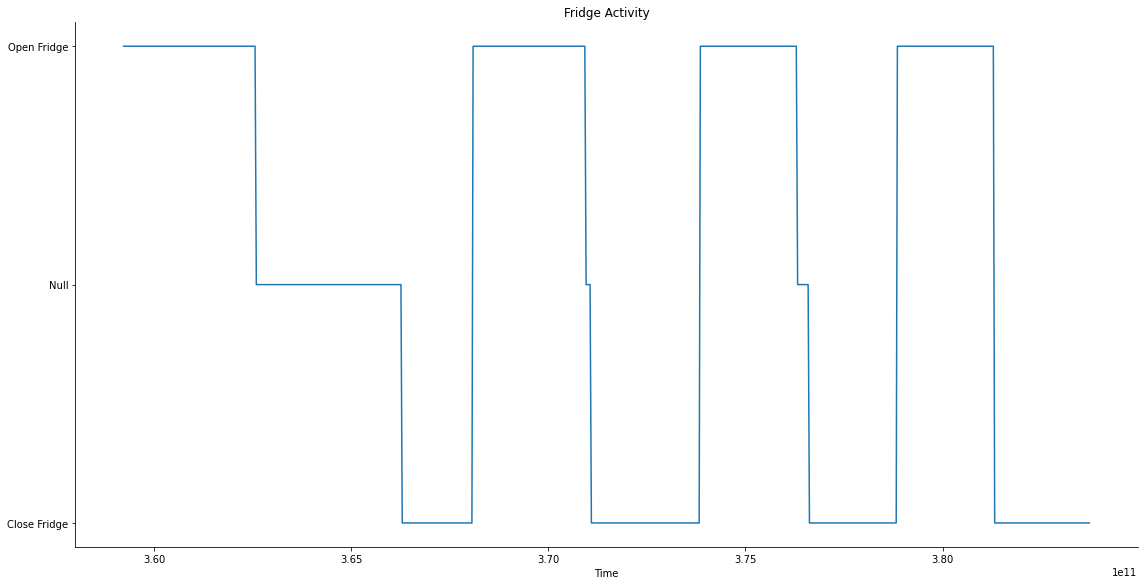

In [13]:
grid = sns.relplot(data=df_lowest_fridge['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Fridge Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()

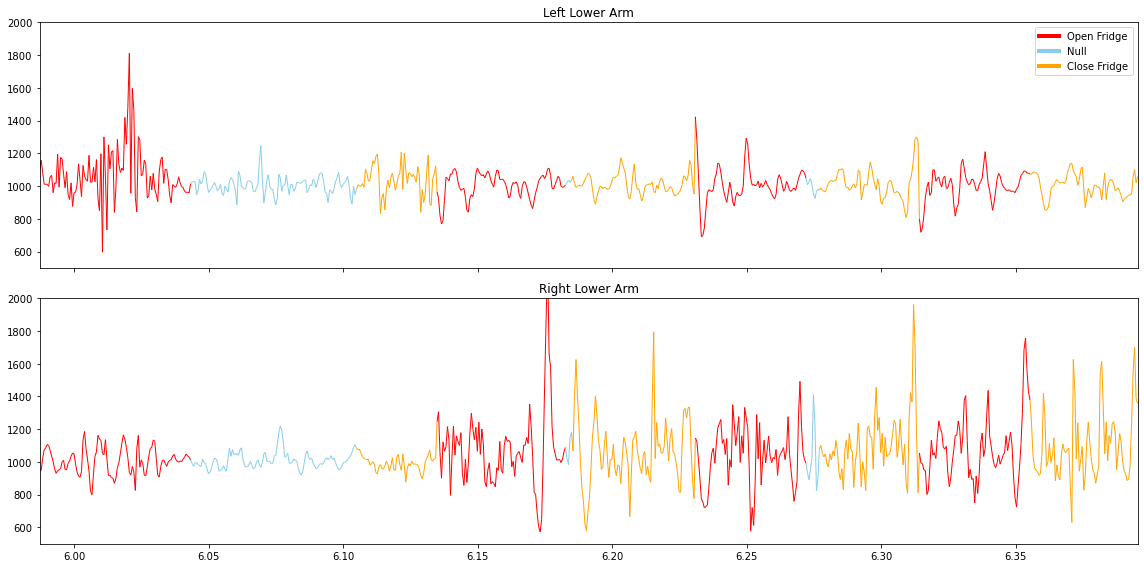

In [113]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

label_dict = {'Open Fridge': -1, 'Null': 0, 'Close Fridge': 1}
cmap = ListedColormap(['red', 'skyblue', 'orange'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

x = df_lowest_fridge.index.values.astype(np.float32) / 60000000000
labels = df_lowest_fridge['activity'].replace(label_dict)

# Left
y = np.sqrt(np.square(df_lowest_fridge[36]) + np.square(df_lowest_fridge[37]) + np.square(df_lowest_fridge[38]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[0].add_collection(lc)

axs[0].set_title('Left Lower Arm')
axs[0].set_xlim(x[0], x[-1])
axs[0].set_ylim(500, 2000)

# Right
y = np.sqrt(np.square(df_lowest_fridge[18]) + np.square(df_lowest_fridge[19]) + np.square(df_lowest_fridge[20]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[1].add_collection(lc)

axs[1].set_title('Right Lower Arm')
axs[1].set_xlim(x[0], x[-1])
axs[1].set_ylim(500, 2000)

axs[0].legend(
    [
        Line2D([0], [0], color='red', lw=4),
        Line2D([0], [0], color='skyblue', lw=4),
        Line2D([0], [0], color='orange', lw=4)
    ],
    label_dict.keys()
)

plt.tight_layout()
plt.show()

In [137]:
df_lowest_dishwasher = df_lowest.loc['24min 48s 71ms': '25min 56s 159ms']

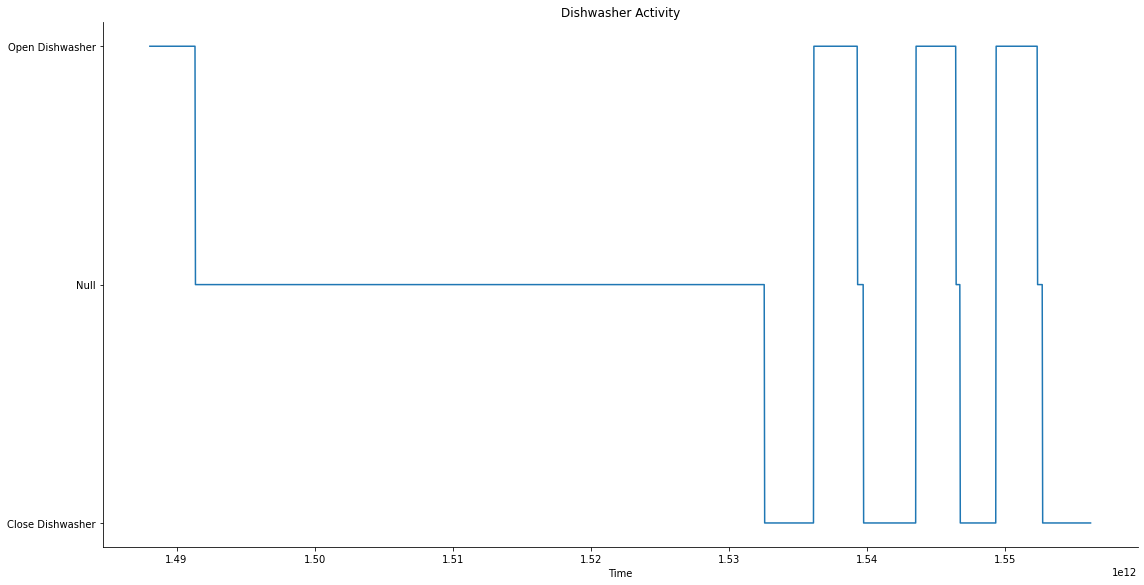

In [138]:
grid = sns.relplot(data=df_lowest_dishwasher['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Dishwasher Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()

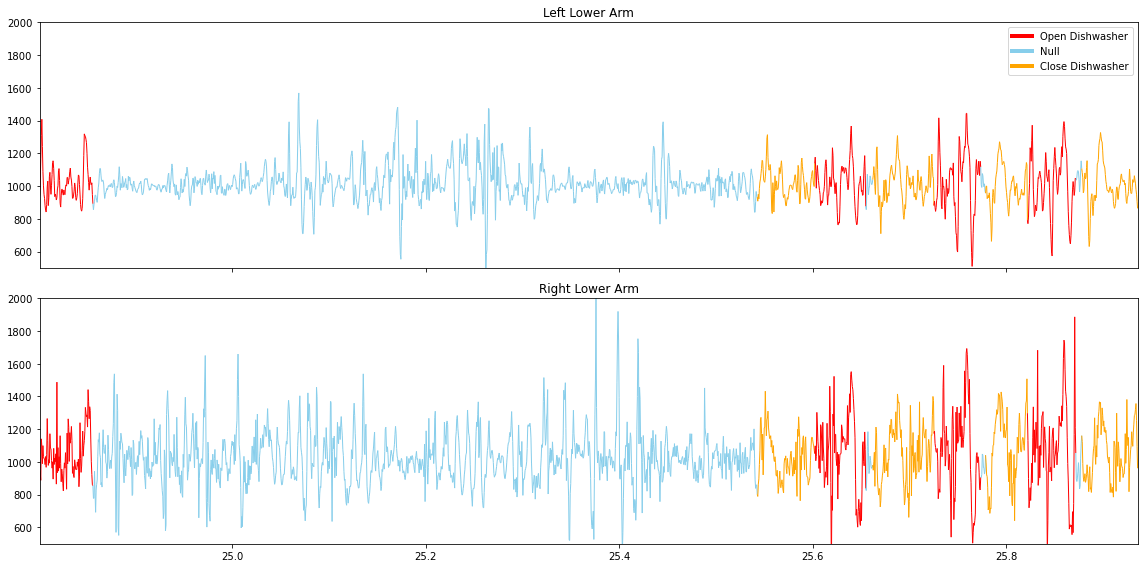

In [140]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

label_dict = {'Open Dishwasher': -1, 'Null': 0, 'Close Dishwasher': 1}
cmap = ListedColormap(['red', 'skyblue', 'orange'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

x = df_lowest_dishwasher.index.values.astype(np.float32) / 60000000000
labels = df_lowest_dishwasher['activity'].replace(label_dict)

# Left
y = np.sqrt(np.square(df_lowest_dishwasher[36]) + np.square(df_lowest_dishwasher[37]) + np.square(df_lowest_dishwasher[38]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[0].add_collection(lc)

axs[0].set_title('Left Lower Arm')
axs[0].set_xlim(x[0], x[-1])
axs[0].set_ylim(500, 2000)

# Right
y = np.sqrt(np.square(df_lowest_dishwasher[18]) + np.square(df_lowest_dishwasher[19]) + np.square(df_lowest_dishwasher[20]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(labels)
lc.set_linewidth(1)
line = axs[1].add_collection(lc)

axs[1].set_title('Right Lower Arm')
axs[1].set_xlim(x[0], x[-1])
axs[1].set_ylim(500, 2000)

axs[0].legend(
    [
        Line2D([0], [0], color='red', lw=4),
        Line2D([0], [0], color='skyblue', lw=4),
        Line2D([0], [0], color='orange', lw=4)
    ],
    label_dict.keys()
)

plt.tight_layout()
plt.show()